# Tutorial: Basics of Iterative Inference Programming in Gen

This tutorial introduces the basics of inference programming in Gen.
In particular, in this notebook we'll focus on _iterative_
inference programs, which include Markov chain Monte Carlo algorithms.

## The task: curve-fitting with outliers

Suppose we have a dataset of points in the $x,y$ plane that is _mostly_ explained by a linear relationship, but which also has several outliers. Our goal will be to automatically identify the outliers, and to find a linear relationship (a slope and intercept, as well as an inherent noise level) that explains rest of the points:

<img src="./images/example-inference.png" alt="See https://dspace.mit.edu/bitstream/handle/1721.1/119255/MIT-CSAIL-TR-2018-020.pdf, Figure 2(a))" width="600"/>

This is a simple inference problem. But it has two features that make it ideal for introducing  concepts in modeling and inference. 

1. First, we want not only to estimate the slope and intercept of the line that best fits the data, but also to classify each point as an inlier or outlier; that is, there are a large number of latent variables of interest, enough to make importance sampling an unreliable method (absent a more involved custom proposal that does the heavy lifting). 
2. Second, several of the parameters we're estimating (the slope and intercept) are continuous and amenable to gradient-based search techniques, which will allow us to explore Gen's optimization capabilities.

Let's get started!

## Outline

**Section 1.** [Writing the model: a first attempt](#writing-model)

**Section 2.** [Visualizing the model's behavior](#visualizing)

**Section 3.** [ The problem with generic importance sampling ](#importance)

**Section 4.** [MCMC Inference Part 1: Block Resimulation](#mcmc-1)

**Section 5.** [MCMC Inference Part 2: Gaussian Drift](#mcmc-2)

**Section 6.** [MCMC Inference Part 3: Proposals based on heuristics](#mcmc-3)

**Section 7.** [MAP Optimization](#map)

In [1]:
import Random, Logging
using Gen, Plots

# Disable logging, because @animate is verbose otherwise
Logging.disable_logging(Logging.Info);


##### Legend:

* red points: outliers;
* blue points: inliers (i.e. regular data);
* dark grey shading: noise associated with inliers; and
* light grey shading: noise associated with outliers.

Note that an outlier can occur anywhere — including close to the line — and
that our model is capable of generating datasets in which the vast majority
of points are outliers.

## 1. Writing the model <a name="writing-model"></a>

We begin, as usual, by writing a model: a generative function responsible
(conceptually) for simulating a synthetic dataset.

Our model will take as input a vector of `x` coordinates, and produce as
output corresponding `y` coordinates. 

We will also use this opportunity to introduce some syntactic sugar.
As described in the previous notebook, random choices in Gen are given
_addresses_ using the syntax `{addr} ~ distribution(...)`. But this can
be a bit verbose, and often leads to code that looks like the following:

```julia
x = {:x} ~ normal(0, 1)
slope = {:slope} ~ normal(0, 1)
```

In these examples, the variable name is duplicated as the address of the
random choice. Because this is a common pattern, Gen provides syntactic
sugar that makes it nicer to use:

```julia
# Desugars to "x = {:x} ~ normal(0, 1)"
x ~ normal(0, 1)
# Desugars to "slope = {:slope} ~ normal(0, 1)"
slope ~ normal(0, 1)
```

Note that sometimes, it is still necessary to use the `{...}` form, for example
in loops:

```julia
# INVALID:
for i=1:10
    y ~ normal(0, 1) # The name :y will be used more than once!!
    println(y)
end

# VALID:
for i=1:10
    y = {(:y, i)} ~ normal(0, 1) # OK: the address is different each time.
    println(y)
end
```

We'll use this new syntax for writing our model of linear regression with
outliers. As we've seen before, the model generates parameters from a prior,
and then simulates data based on those parameters:

In [2]:
@gen function regression_with_outliers(xs::Vector{<:Real})
    # First, generate some parameters of the model. We make these
    # random choices, because later, we will want to infer them
    # from data. The distributions we use here express our assumptions
    # about the parameters: we think the slope and intercept won't be
    # too far from 0; that the noise is relatively small; and that
    # the proportion of the dataset that don't fit a linear relationship
    # (outliers) could be anything between 0 and 1.
    slope ~ normal(0, 2)
    intercept ~ normal(0, 2)
    noise ~ gamma(1, 1)
    prob_outlier ~ uniform(0, 1)

    # Next, we generate the actual y coordinates.
    n = length(xs)
    ys = Float64[]

    for i = 1:n
        # Decide whether this point is an outlier, and set
        # mean and standard deviation accordingly
        if ({:data => i => :is_outlier} ~ bernoulli(prob_outlier))
            (mu, std) = (0., 10.)
        else
            (mu, std) = (xs[i] * slope + intercept, noise)
        end
        # Sample a y value for this point
        push!(ys, {:data => i => :y} ~ normal(mu, std))
    end
    ys
end;


## 2. What our model is doing: visualizing the prior 

Let's visualize what our model is doing by drawing some samples from the
prior.

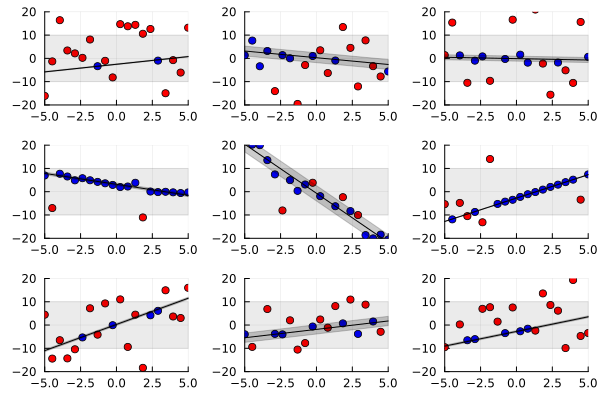

In [10]:
# Generate nine traces and visualize them
include("visualization/regression_viz.jl")
xs     = collect(range(-5, stop=5, length=20))
traces = [Gen.simulate(regression_with_outliers, (xs,)) for i in 1:9];
Plots.plot([visualize_trace(t) for t in traces]...)


##### Legend:

* red points: outliers;
* blue points: inliers (i.e. regular data);
* dark grey shading: noise associated with inliers; and
* light grey shading: noise associated with outliers.

Note that an outlier can occur anywhere — including close to the line — and
that our model is capable of generating datasets in which the vast majority
of points are outliers.

## 3. The problem with generic importance sampling  <a name="generic-importance"></a>

To motivate the need for more complex inference algorithms, let's begin by
using the simple importance sampling method from the previous tutorial, and
thinking about where it fails.

First, let us create a synthetic dataset to do inference _about_.

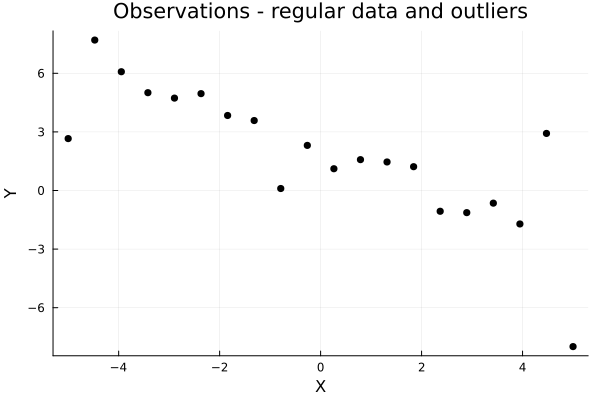

In [11]:
function make_synthetic_dataset(n)
    Random.seed!(1)
    prob_outlier = 0.2
    true_inlier_noise = 0.5
    true_outlier_noise = 5.0
    true_slope = -1
    true_intercept = 2
    xs = collect(range(-5, stop=5, length=n))
    ys = Float64[]
    for (i, x) in enumerate(xs)
        if rand() < prob_outlier
            y = randn() * true_outlier_noise
        else
            y = true_slope * x + true_intercept + randn() * true_inlier_noise
        end
        push!(ys, y)
    end
    (xs, ys)
end

(xs, ys) = make_synthetic_dataset(20);
Plots.scatter(xs, ys, color="black", xlabel="X", ylabel="Y",
              label=nothing, title="Observations - regular data and outliers")


We will to express our _observations_ as a `ChoiceMap` that constrains the
values of certain random choices to equal their observed values. Here, we
want to constrain the values of the choices with address `:data => i => :y`
(that is, the sampled $y$ coordinates) to equal the observed $y$ values.
Let's write a helper function that takes in a vector of $y$ values and
creates a `ChoiceMap` that we can use to constrain our model:

In [12]:
function make_constraints(ys::Vector{Float64})
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;


We can apply it to our dataset's vector of `ys` to make a set of constraints
for doing inference:

In [13]:
observations = make_constraints(ys);


In [17]:
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;


## 5. MCMC Inference Part 2: Gaussian Drift MH  <a name="mcmc-2"></a>

In [14]:
@gen function line_proposal(current_trace)
    slope ~ normal(current_trace[:slope], 0.5)
    intercept ~ normal(current_trace[:intercept], 0.5)
end;


This is often called a "Gaussian drift" proposal, because it essentially amounts to proposing steps of a random walk. (What makes it different from a random walk is that we will still use an MH accept/reject step to make sure we don't wander into areas of very low probability.)

To use the proposal, we write:

```julia
(tr, did_accept) = mh(tr, line_proposal, ())
```

Two things to note:

1. We no longer need to pass a selection of addresses. Instead, Gen assumes
   that whichever addresses are sampled by the proposal (in this case,
   `:slope` and `:intercept`) are being proposed to.

2. The argument list to the proposal is an empty tuple, `()`. The
   `line_proposal` generative function does expect an argument, the previous
   trace, but this is supplied automatically to all MH custom proposals
   (a proposal generative function for use with `mh` must take as its first argument the 
   current trace of the model).

Let's swap it into our update:

In [15]:
function gaussian_drift_update(tr)
    # Gaussian drift on line params
    (tr, _) = mh(tr, line_proposal, ())

    # Block resimulation: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end

    # Block resimulation: Update the prob_outlier parameter
    (tr, w) = mh(tr, select(:prob_outlier))
    (tr, w) = mh(tr, select(:noise))
    tr
end;


If we compare the Gaussian Drift proposal visually with our old algorithm, we
can see the new behavior:

Plots.AnimatedGif("/var/folders/lk/nt9x15z12v3_kjy4_vwkcf_r0000gn/T/jl_nQ9a1Slqzm.gif")
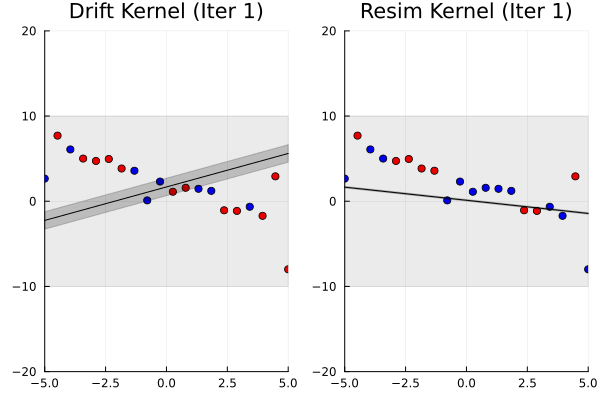

In [ ]:
tr1, = generate(regression_with_outliers, (xs,), observations)
tr2 = tr1

viz = Plots.@animate for i in 1:300
    global tr1, tr2
    tr1 = gaussian_drift_update(tr1)
    tr2 = block_resimulation_update(tr2)
    Plots.plot(visualize_trace(tr1; title="Drift Kernel (Iter $i)"),
               visualize_trace(tr2; title="Resim Kernel (Iter $i)"))
end;
gif(viz)


-----------

### Exercise: Analyzing the algorithms

Run the cell above several times. Compare the two
algorithms with respect to the following:

- How fast do they find a relatively good line?

- Does one of them tend to get stuck more than the other? Under what
  conditions? Why?

-----------

A more quantitative comparison demonstrates that our change has
improved our inference quality:

In [18]:
function gaussian_drift_inference(xs, observations)
    (tr, _) = generate(regression_with_outliers, (xs,), observations)
    for iter=1:500
        tr = gaussian_drift_update(tr)
    end
    tr
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = gaussian_drift_inference(xs, observations)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))


  1.049998 seconds (11.99 M allocations: 699.023 MiB, 12.45% gc time, 0.53% compilation time)


  0.988519 seconds (11.99 M allocations: 698.890 MiB, 8.33% gc time)


  0.994989 seconds (11.99 M allocations: 698.890 MiB, 8.28% gc time)


  0.985671 seconds (11.99 M allocations: 698.890 MiB, 8.32% gc time)


  0.987639 seconds (11.99 M allocations: 698.890 MiB, 8.38% gc time)


  0.996418 seconds (11.99 M allocations: 698.890 MiB, 8.31% gc time)


  0.984321 seconds (11.99 M allocations: 698.890 MiB, 8.45% gc time)


  0.989671 seconds (11.99 M allocations: 698.890 MiB, 8.39% gc time)


  0.998014 seconds (11.99 M allocations: 698.890 MiB, 8.29% gc time)


  0.983963 seconds (11.99 M allocations: 698.890 MiB, 8.36% gc time)
Log probability: -42.76321832747993
